In [1]:
import numpy as np
from numpy.linalg import pinv

import pandas as pd

import networkx as nx
import pydot
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=4, suppress=True)
pd.set_option('precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Summary

We develop code for analytically solving MDPs for their states' value and variance.
We then test against simulations to ensure that they match.

## Simulation Setup

We want to check the accuracy of our analytic methods vs. simulation.

Let's write some code to simulate trajectories.
We need:

1. Tabular features
2. A way of generating trajectories
3. A way of calculating returns
3. A way of calculating the experimental quantities to check our analysis.

In [2]:
class Int2Unary:
    """
    Convert integer to unary representation (e.g., for tabular case)
    """
    def __init__(self, length):
        self.length = length
        self._array = np.eye(length)

    def __call__(self, x):
        return self._array[x]

In [3]:
def trajectory_gen(P, R, s0=None):
    """Create a generator that """
    if s0 is None:
        s = 1
    else:
        s = s0
    # Problem setup
    ns = len(P)
    states = np.arange(ns)
    I = np.eye(ns)
    
    # Initial state
    x = np.zeros(ns)
    x[s] = 1
    while True:
        # Sample the next state
        dp = np.dot(x, P)
        sp = np.random.choice(states, p=dp)
        xp = I[sp]
        r = R[s, sp]
        
        # Yield the result
        yield (s, r, sp)
        # Set up for the next iteration
        s = sp
        x = xp

In [4]:
def compute_return(steps, gmfunc):
    ret = []
    g = 0
    for step in reversed(steps):
        s, r, sp = step
        g = r + gmfunc(sp)*g
        ret.append((s, g, sp))
    return list(reversed(ret))

def compute_lambda_return(steps, gmfunc, lmfunc, vfunc):
    pass

Now we can define MDPs, solve them, and simulate them.

# Chicken Problem

First, a problem similar to the game "chicken", where the choice is to either advance or return to the start.
Advancing all the way to the end yields a reward of 1, indicating successfully bumping into the wall.

In [5]:
# Chicken problem solved analytically
nstates = ns = 6
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
P = np.diag(np.ones(ns-1), 1) * 0.5
P[:,0] = 0.5
P[-1, 0] = 1

# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns)) * 0.9
R[-2, -1] = 1.0
r = np.sum(P*R, axis=1)

# Discount
gmvec = np.ones(ns)
gmvec[0] = 0
G = np.diag(gmvec)

# Bootstrapping
lmvec = np.zeros(ns)
L = np.diag(lmvec)

# Function approximation
X = np.eye(ns)

# Value function
v_pi = pinv(I - P @ G) @ r


# From sobel, recursive expected variance contribution?
# T = -v_pi**2
# for i in range(ns):
#     for j in range(ns):
#         T[i] += P[i,j] * (R[i,j] + gmvec[j]*v_pi[j])**2

# Alternatively,
T = np.sum(P * (R + G @ v_pi)**2, axis=1) - v_pi**2
        
# Variance (again from Sobel)
v_var = pinv(I - P @ G @ G) @ T 

# Define the experiment
nsteps = 100000
gmfunc = lambda x: gmvec[x]
lmfunc = lambda x: lmvec[x]
phi = Int2Unary(nstates)

# Generate a trajectory
gen = trajectory_gen(P, R)
slst = [next(gen) for i in range(nsteps)]

# Compute the MC-return
glst = compute_return(slst, gmfunc)
# xlst = [(phi(s), r, phi(sp)) for s, r, sp in steps] 

# Compare analytical and experimental values
gdf = pd.DataFrame(glst, columns=['s', 'g', 'sp'])
grouped = pd.groupby(gdf, 's')
true_value = pd.Series(v_pi, name='true_value')
true_var = pd.Series(v_var, name='true_var')
exp_value = grouped.aggregate({'g': np.mean}).rename(columns={'g': 'exp_value'})
exp_var = grouped.aggregate({'g': np.var}).rename(columns={'g': 'exp_var'})

combined = pd.concat([true_value, exp_value, true_var, exp_var], axis=1)
display(combined)

true_value  exp_value  true_var  exp_var
0      0.0312     0.0326    0.0303   0.0315
1      0.0625     0.0648    0.0586   0.0606
2      0.1250     0.1294    0.1094   0.1127
3      0.2500     0.2603    0.1875   0.1926
4      0.5000     0.5037    0.2500   0.2501
5      0.0000     0.0000    0.0000   0.0000

## Drawing the MDP

We attempt to use `networkx` and `pydot` to render the MDPs.
They are not ideal, but at least allow us to quickly check for errors.

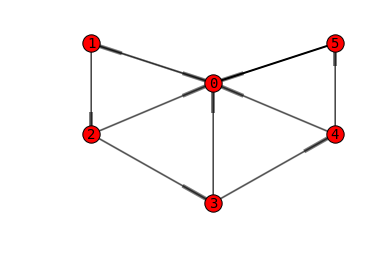

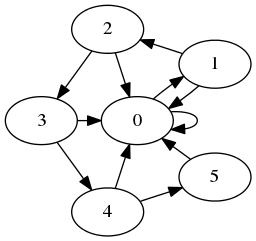

In [6]:
# Convert to networkx graph
graph = nx.DiGraph(P)

# Initial layout
pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)
pos = nx.layout.shell_layout(graph)
# pos = nx.layout.fruchterman_reingold_layout(graph)
pos = nx.layout.spectral_layout(graph)

# Nodes
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_labels(graph, pos, font_size=14, font_family='monospace')

# Edges
eweights = {(i,j): P[i,j] for i,j in graph.edges()}
ecolors = [eweights[k] for k in graph.edges()]
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), 
                       edge_color=ecolors, 
                       edge_cmap=plt.cm.Greys, 
                       edge_vmax=1.0, 
                       edge_vmin=0.0,
                       width=2.0,
                       arrows=None)

# To get arrowheads
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), alpha=0.5, arrows=True) 


# nx.draw_networkx_edge_labels(graph, pos, edge_labels=eweights)

plt.axis('off')
plt.show()

# Now with Pydot as an alternative...
ptg = nx.nx_pydot.to_pydot(graph)
img = ptg.create_png(prog='twopi')
Image(img)

# Rich & Craig Counterexample

Here is the counterexample to the Tamar paper that Rich and Craig came up with.
Note that the variance of the return is always zero, even if the variance of the immediate reward may not be.

In [7]:
# Rich and Craig's counterexample
nstates = ns = 6
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
P = np.zeros((ns, ns))
P[0, 1:3] = 0.5 
P[-3:-1, -1] = 1
P[1, 3] = 1
P[2, 4] = 1
P[-1, 0] = 1

# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns))
R[0, 1] = 1
R[0, 2] = -1
R[3, 5] = -1
R[4, 5] = 1
r = np.sum(P*R, axis=1)

# Discount
gmvec = np.ones(ns)
gmvec[0] = 0
G = np.diag(gmvec)

# Bootstrapping
lmvec = np.zeros(ns)
L = np.diag(lmvec)

# Function approximation
X = np.eye(ns)

# Value function
v_pi = pinv(I - P @ G) @ r


# From sobel, recursive expected variance contribution?
# T = -v_pi**2
# for i in range(ns):
#     for j in range(ns):
#         T[i] += P[i,j] * (R[i,j] + gmvec[j]*v_pi[j])**2

# Alternatively,
T = np.sum(P * (R + G @ v_pi)**2, axis=1) - v_pi**2
        
# Variance (again from Sobel)
v_var = pinv(I - P @ G @ G) @ T 

# Define the experiment
nsteps = 100000
gmfunc = lambda x: gmvec[x]
lmfunc = lambda x: lmvec[x]
phi = Int2Unary(nstates)

# Generate a trajectory
gen = trajectory_gen(P, R)
slst = [next(gen) for i in range(nsteps)]

# Compute the MC-return
glst = compute_return(slst, gmfunc)
# xlst = [(phi(s), r, phi(sp)) for s, r, sp in steps] 

# Compare analytical and experimental values
gdf = pd.DataFrame(glst, columns=['s', 'g', 'sp'])
grouped = pd.groupby(gdf, 's')
true_value = pd.Series(v_pi, name='true_value')
true_var = pd.Series(v_var, name='true_var')
exp_value = grouped.aggregate({'g': np.mean}).rename(columns={'g': 'exp_value'})
exp_var = grouped.aggregate({'g': np.var}).rename(columns={'g': 'exp_var'})

combined = pd.concat([true_value, exp_value, true_var, exp_var], axis=1)
display(combined)

true_value  exp_value  true_var  exp_var
0      0.0000    -0.0000   -0.0000   0.0000
1     -1.0000    -1.0000    0.0000   0.0000
2      1.0000     1.0000   -0.0000   0.0000
3     -1.0000    -1.0000    0.0000   0.0000
4      1.0000     1.0000    0.0000   0.0000
5      0.0000     0.0000    0.0000   0.0000

In [8]:
# Convert to networkx graph
graph = nx.DiGraph(P)

# Initial layout
pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)
pos = nx.layout.shell_layout(graph)
# pos = nx.layout.fruchterman_reingold_layout(graph)
pos = nx.layout.spectral_layout(graph)

# Nodes
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_labels(graph, pos, font_size=14, font_family='monospace')

# Edges
eweights = {(i,j): P[i,j] for i,j in graph.edges()}
ecolors = [eweights[k] for k in graph.edges()]
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), 
                       edge_color=ecolors, 
                       edge_cmap=plt.cm.Greys, 
                       edge_vmax=1.0, 
                       edge_vmin=0.0,
                       width=2.0,
                       arrows=None)

# To get arrowheads
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), alpha=0.5, arrows=True) 


# nx.draw_networkx_edge_labels(graph, pos, edge_labels=eweights)

plt.axis('off')
plt.show()

# Now with Pydot as an alternative...
ptg = nx.nx_pydot.to_pydot(graph)
img = ptg.create_png(prog='twopi')
Image(img)

# 1-D Random Walk 

I haven't really analyzed this one yet, so beware.

In [9]:
# A 1D random walk
nstates = ns = 6
I = np.eye(ns)

# Probability of transitioning from state s_i --> s_j = P[i,j]
P = np.diag(np.ones(ns-1), 1) * 0.5
P += P.T
P[0,0] = 0.5
P[-1, -1] = 0.5

# Expected reward for transitioning from s_i --> s_j = R[i,j]
R = np.zeros((ns, ns))
R[0,0] = 1
R[-1, -1] = -1
r = np.sum(P*R, axis=1)

# Discount
gmvec = np.ones(ns)*0.9
G = np.diag(gmvec)

# Bootstrapping
lmvec = np.zeros(ns)
L = np.diag(lmvec)

# Function approximation
X = np.eye(ns)


# Value function
v_pi = pinv(I - P @ G) @ r


# # From sobel, recursive expected variance contribution?
# T = -v_pi**2
# for i in range(ns):
#     for j in range(ns):
#         T[i] += P[i,j] * (R[i,j] + gmvec[j]*v_pi[j])**2

# Alternatively,
T = np.sum(P * (R + G @ v_pi)**2, axis=1) - v_pi**2
        
# Variance (again from Sobel)
v_var = pinv(I - P @ G @ G) @ T 

# Define the experiment
nsteps = 100000
gmfunc = lambda x: gmvec[x]
lmfunc = lambda x: lmvec[x]
phi = Int2Unary(nstates)

# Generate a trajectory
gen = trajectory_gen(P, R)
slst = [next(gen) for i in range(nsteps)]

# Compute the MC-return
glst = compute_return(slst, gmfunc)
# xlst = [(phi(s), r, phi(sp)) for s, r, sp in steps] 

# Compare analytical and experimental values
gdf = pd.DataFrame(glst, columns=['s', 'g', 'sp'])
grouped = pd.groupby(gdf, 's')
true_value = pd.Series(v_pi, name='true_value')
true_var = pd.Series(v_var, name='true_var')
exp_value = grouped.aggregate({'g': np.mean}).rename(columns={'g': 'exp_value'})
exp_var = grouped.aggregate({'g': np.var}).rename(columns={'g': 'exp_var'})

combined = pd.concat([true_value, exp_value, true_var, exp_var], axis=1)
display(combined)

true_value  exp_value  true_var  exp_var
0      1.5892     1.5902    2.7120   2.7210
1      0.8312     0.8246    2.2376   2.2429
2      0.2580     0.2590    1.9268   1.9712
3     -0.2580    -0.2651    1.9268   1.9934
4     -0.8312    -0.8663    2.2376   2.3566
5     -1.5892    -1.6642    2.7120   2.8828

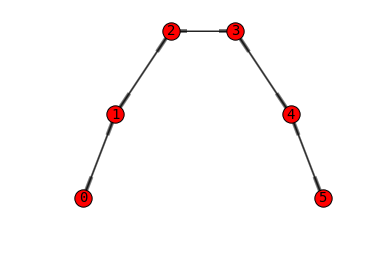

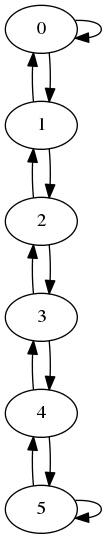

In [10]:
# Convert to networkx graph
graph = nx.DiGraph(P)

# Initial layout
pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)
pos = nx.layout.shell_layout(graph)
# pos = nx.layout.fruchterman_reingold_layout(graph)
pos = nx.layout.spectral_layout(graph)

# Nodes
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_labels(graph, pos, font_size=14, font_family='monospace')

# Edges
eweights = {(i,j): P[i,j] for i,j in graph.edges()}
ecolors = [eweights[k] for k in graph.edges()]
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), 
                       edge_color=ecolors, 
                       edge_cmap=plt.cm.Greys, 
                       edge_vmax=1.0, 
                       edge_vmin=0.0,
                       width=2.0,
                       arrows=None)

# To get arrowheads
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), alpha=0.5, arrows=True) 


# nx.draw_networkx_edge_labels(graph, pos, edge_labels=eweights)

plt.axis('off')
plt.show()

# Now with Pydot as an alternative...
ptg = nx.nx_pydot.to_pydot(graph)
img = ptg.create_png(prog='twopi')
Image(img)